In [1]:
import os
from datetime import datetime 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### First look of one condition patient

In [2]:
my_file = './condition/condition_1.csv'
df_act = pd.read_csv(my_file)
df_act.head(10)

,timestamp,date,activity
0,2003-05-07 12:00:00,2003-05-07,0
1,2003-05-07 12:01:00,2003-05-07,143
2,2003-05-07 12:02:00,2003-05-07,0
3,2003-05-07 12:03:00,2003-05-07,20
4,2003-05-07 12:04:00,2003-05-07,166
5,2003-05-07 12:05:00,2003-05-07,160
6,2003-05-07 12:06:00,2003-05-07,17
7,2003-05-07 12:07:00,2003-05-07,646
8,2003-05-07 12:08:00,2003-05-07,978
9,2003-05-07 12:09:00,2003-05-07,306


In [3]:
df_act.activity.describe(percentiles=[0.01,0.1,0.25,0.5,0.75,0.9,0.99])

count    23244.000000
mean       146.948030
std        294.592424
min          0.000000
1%           0.000000
10%          0.000000
25%          0.000000
50%          9.000000
75%        172.000000
90%        469.000000
99%       1300.000000
max       3526.000000
Name: activity, dtype: float64

In [4]:
df_act['log1_act'] = np.log10(1+df_act.activity)
df_act['non_zero'] = (df_act.activity>0).astype(int)

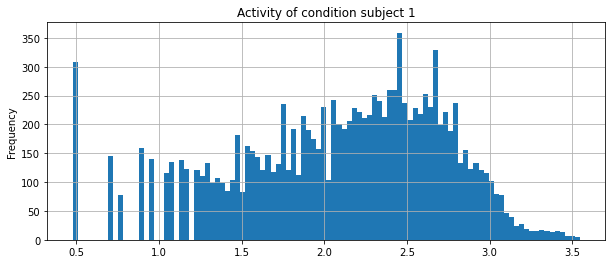

In [5]:

plt.figure(figsize=(10,4))
np.log10(df_act[df_act.non_zero==1].activity).plot(kind='hist', bins=100)
plt.title('Activity of condition subject 1')
plt.grid()
plt.show()

### First look of one control patient

In [6]:
my_file = './control/control_3.csv'
df_act = pd.read_csv(my_file)
df_act.head(10)

,timestamp,date,activity
0,2002-11-06 15:00:00,2002-11-06,0
1,2002-11-06 15:01:00,2002-11-06,0
2,2002-11-06 15:02:00,2002-11-06,0
3,2002-11-06 15:03:00,2002-11-06,0
4,2002-11-06 15:04:00,2002-11-06,0
5,2002-11-06 15:05:00,2002-11-06,0
6,2002-11-06 15:06:00,2002-11-06,0
7,2002-11-06 15:07:00,2002-11-06,0
8,2002-11-06 15:08:00,2002-11-06,0
9,2002-11-06 15:09:00,2002-11-06,0


In [7]:
df_act.activity.describe(percentiles=[0.01,0.1,0.25,0.5,0.75,0.9,0.99])

count    65407.000000
mean        77.011207
std        228.485709
min          0.000000
1%           0.000000
10%          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
90%        296.000000
99%       1142.000000
max       3974.000000
Name: activity, dtype: float64

In [8]:
df_act['log1_act'] = np.log10(1+df_act.activity)
df_act['non_zero'] = (df_act.activity>0).astype(int)

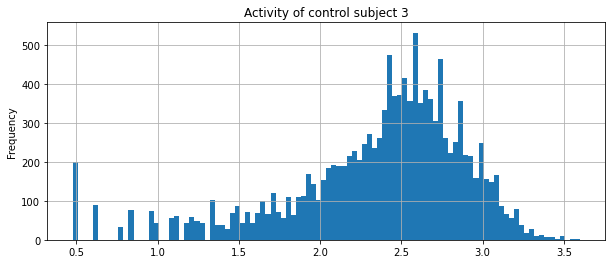

In [9]:
plt.figure(figsize=(10,4))
np.log10(df_act[df_act.non_zero==1].activity).plot(kind='hist', bins=100)
plt.title('Activity of control subject 3')
plt.grid()
plt.show()

### Plot the activity for control group

In [10]:
def get_data(path):
    dirs = os.listdir(path)
    combine_df = []
    for filepath in dirs:
        source = filepath.split('.')[0]
        if filepath.endswith('.csv'):
            X = pd.read_csv(path + filepath, parse_dates=['timestamp'], index_col='timestamp')
            X['source'] = source
            combine_df.append(X)  
    return combine_df

In [11]:
combine_df = get_data('./control/')
controls = []
for control in combine_df:
    control_df = pd.DataFrame(columns=['mean_activity', 'zero_activity_proportion'])
    control_df['mean_activity'] = control.activity.resample('H').mean()
    control_df['zero_activity_proportion'] = [data[1].tolist().count(0) for data in control.activity.resample('H')]
    controls.append(control_df)

### Plot the activity for condition group

In [12]:
combine_df = get_data('./condition/')
conditions = []
for condition in combine_df:
    condition_df = pd.DataFrame(columns=['mean_activity', 'zero_activity_proportion'])
    condition_df['mean_activity'] = condition.activity.resample('H').mean()
    condition_df['zero_activity_proportion'] = [data[1].tolist().count(0) for data in condition.activity.resample('H')]
    conditions.append(condition_df)

### Zero activiy of both groups

In [13]:
def to_clock(x):
    d = datetime.strptime(f'{x}:00', '%H:%M')
    return d.strftime('%I:%M %p')

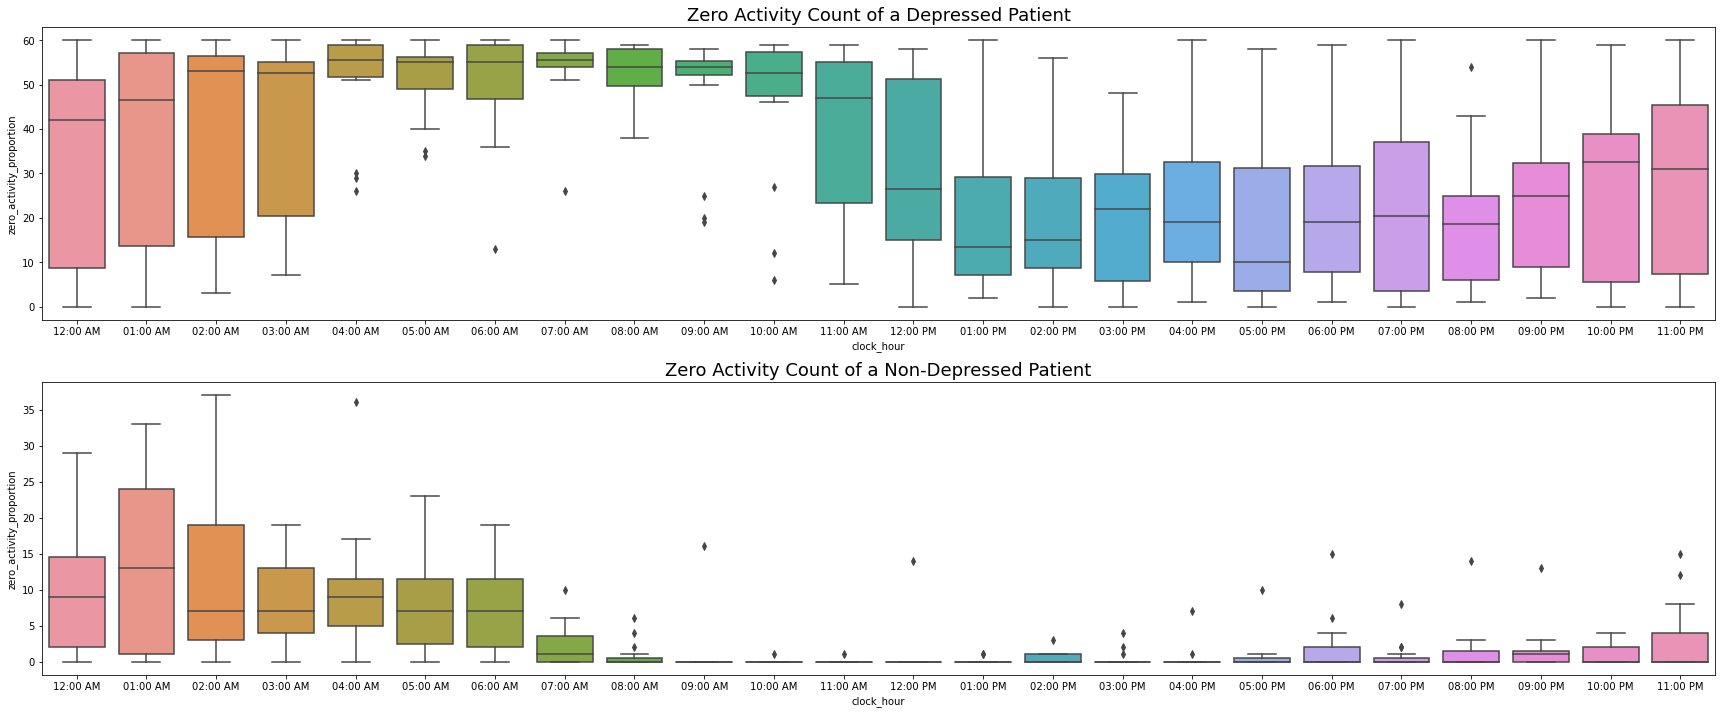

In [14]:
fig, axes = plt.subplots(2, 1, figsize=(24, 10))
df = conditions[12].reset_index()
df['hour'] = [d.hour for d in df.timestamp]
df = df.sort_values('hour')
df['clock_hour'] = df['hour'].apply(lambda x: to_clock(x))
sns.boxplot(x='clock_hour', y='zero_activity_proportion', data=df, ax=axes[0])
axes[0].set_title('Zero Activity Count of a Depressed Patient', fontsize=18)

df = controls[2].reset_index()
df['hour'] = [d.hour for d in df.timestamp]
df = df.sort_values('hour')
df['clock_hour'] = df['hour'].apply(lambda x: to_clock(x))
sns.boxplot(x='clock_hour', y='zero_activity_proportion', data=df, ax=axes[1])
axes[1].set_title('Zero Activity Count of a Non-Depressed Patient', fontsize=18)

fig.tight_layout(pad=1.0)
plt.show()

### Prepare the data to examine control and condition groups

In [15]:
daily_threshold = 10
mean_list_control = []
std_list_control = []
q99_list_control = []
std_q99_list_control = []

for i in range(32):
    j = 1+i
    my_file = './control/control_' + str(j) + '.csv'
    df_temp = pd.read_csv(my_file)
    
    df_temp_by_date = df_temp.groupby(['date'], as_index=False).agg(
        n = pd.NamedAgg(column='activity', aggfunc='count'),
        mean_act = pd.NamedAgg(column='activity', aggfunc='mean'),
        q99_act = pd.NamedAgg(column='activity', aggfunc=lambda x : np.percentile(a=x, q=99)),
        max_act = pd.NamedAgg(column='activity', aggfunc='max')
    )
    df_temp_by_date = df_temp_by_date[df_temp_by_date.n==1440]
    df_temp_by_date = df_temp_by_date[df_temp_by_date.mean_act > daily_threshold]
    mean_temp = df_temp_by_date.mean_act.mean() 
    std_temp = df_temp_by_date.mean_act.std() 
    mean_q99_temp = df_temp_by_date.q99_act.mean() 
    std_q99_temp = df_temp_by_date.q99_act.std() 
    mean_list_control.append(mean_temp)
    std_list_control.append(std_temp)
    q99_list_control.append(mean_q99_temp)
    std_q99_list_control.append(std_q99_temp)

In [16]:
df = pd.read_csv('./scores.csv')
df_condition = df[df.number.str.contains('condition')].copy()
df_control = df[df.number.str.contains('control')].copy()

In [17]:
control_stats =  pd.DataFrame(zip(df_control.number, mean_list_control, q99_list_control, std_list_control, std_q99_list_control), 
                               columns=['number','Mean_MeanAct','Mean_Q99Act','Std_MeanAct','Std_Q99Act'])
control_stats['CV_MeanAct'] = control_stats.Std_MeanAct / control_stats.Mean_MeanAct
control_stats['CV_Q99Act'] = control_stats.Std_Q99Act / control_stats.Mean_Q99Act
control_stats

,number,Mean_MeanAct,Mean_Q99Act,Std_MeanAct,Std_Q99Act,CV_MeanAct,CV_Q99Act
0,control_1,193.090712,1747.426875,79.180375,488.183345,0.410068,0.279373
1,control_2,407.458697,2044.739048,137.730227,352.116906,0.338023,0.172206
2,control_3,249.641270,1502.540000,52.558532,193.967304,0.210536,0.129093
3,control_4,186.394213,1711.935333,59.268265,298.854188,0.317973,0.174571
4,control_5,246.008987,1403.467059,132.278665,525.196868,0.537699,0.374214
5,control_6,279.535294,2064.458235,124.969577,572.223333,0.447062,0.277178
6,control_7,360.261161,2557.209286,127.277609,1520.288118,0.353293,0.594511
7,control_8,380.200787,1970.728667,125.202102,613.697773,0.329305,0.311407
8,control_9,141.170370,1145.389333,47.241626,269.018427,0.334643,0.234871
9,control_10,290.439782,1865.657143,83.298433,324.491722,0.286801,0.173929


In [18]:
mean_list = []
std_list = []
q99_list = []
std_q99_list = []

for i in range(23):
    j = 1+i
    my_file = './condition/condition_' + str(j) + '.csv'
    df_temp = pd.read_csv(my_file)
    
    df_temp_by_date = df_temp.groupby(['date'], as_index=False).agg(
        n = pd.NamedAgg(column='activity', aggfunc='count'),
        mean_act = pd.NamedAgg(column='activity', aggfunc='mean'),
        q99_act = pd.NamedAgg(column='activity', aggfunc=lambda x : np.percentile(a=x, q=99)),
        max_act = pd.NamedAgg(column='activity', aggfunc='max')
    )
    df_temp_by_date = df_temp_by_date[df_temp_by_date.n==1440]
    df_temp_by_date = df_temp_by_date[df_temp_by_date.mean_act > daily_threshold]
    mean_temp = df_temp_by_date.mean_act.mean() 
    std_temp = df_temp_by_date.mean_act.std() 
    mean_q99_temp = df_temp_by_date.q99_act.mean() 
    std_q99_temp = df_temp_by_date.q99_act.std() 
    mean_list.append(mean_temp)
    std_list.append(std_temp)
    q99_list.append(mean_q99_temp)
    std_q99_list.append(std_q99_temp)

In [19]:
condition_stats = pd.DataFrame(zip(df_condition.number, mean_list, q99_list, std_list, std_q99_list), 
                               columns=['number','Mean_MeanAct','Mean_Q99Act','Std_MeanAct','Std_Q99Act'])
condition_stats['CV_MeanAct'] = condition_stats.Std_MeanAct / condition_stats.Mean_MeanAct
condition_stats['CV_Q99Act'] = condition_stats.Std_Q99Act / condition_stats.Mean_Q99Act
condition_stats

,number,Mean_MeanAct,Mean_Q99Act,Std_MeanAct,Std_Q99Act,CV_MeanAct,CV_Q99Act
0,condition_1,152.199630,1248.365333,59.218240,537.750628,0.389083,0.430764
1,condition_2,211.280738,1538.777368,80.924414,528.810407,0.383018,0.343656
2,condition_3,280.810714,1605.270000,61.577770,287.349708,0.219286,0.179004
3,condition_4,286.064732,1710.240714,166.280241,609.340002,0.581268,0.356289
4,condition_5,172.622371,1300.538571,46.444164,259.816491,0.269051,0.199776
5,condition_6,194.754861,1428.765000,38.794611,153.984219,0.199197,0.107774
6,condition_7,295.975588,1651.887692,148.639974,401.224692,0.502203,0.242889
7,condition_8,200.443750,1804.810000,95.169158,745.719621,0.474792,0.413185
8,condition_9,177.031624,1420.541538,25.805786,151.907215,0.145769,0.106936
9,condition_10,296.403373,1691.552143,84.898469,256.541836,0.286429,0.151661


### Comparison of control vs condition groups

In [20]:
condition_stats.describe()

,Mean_MeanAct,Mean_Q99Act,Std_MeanAct,Std_Q99Act,CV_MeanAct,CV_Q99Act
count,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000
mean,177.359263,1293.282746,60.221801,318.413688,0.327726,0.248803
std,75.725958,335.760931,39.333135,168.601320,0.135601,0.122393
min,65.370585,665.491429,9.301415,96.547265,0.130202,0.106936
25%,120.196612,1030.523544,28.137077,190.752177,0.229600,0.158577
50%,172.622371,1300.538571,60.377039,287.349708,0.286429,0.199776
75%,235.399106,1574.730899,73.919049,389.201044,0.432363,0.349973
max,296.403373,1804.810000,166.280241,745.719621,0.581268,0.572878


In [21]:
condition_stats.describe()

,Mean_MeanAct,Mean_Q99Act,Std_MeanAct,Std_Q99Act,CV_MeanAct,CV_Q99Act
count,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000
mean,177.359263,1293.282746,60.221801,318.413688,0.327726,0.248803
std,75.725958,335.760931,39.333135,168.601320,0.135601,0.122393
min,65.370585,665.491429,9.301415,96.547265,0.130202,0.106936
25%,120.196612,1030.523544,28.137077,190.752177,0.229600,0.158577
50%,172.622371,1300.538571,60.377039,287.349708,0.286429,0.199776
75%,235.399106,1574.730899,73.919049,389.201044,0.432363,0.349973
max,296.403373,1804.810000,166.280241,745.719621,0.581268,0.572878


In [22]:
condition_stats['Group'] = 'Condition'
control_stats['Group'] = 'Control'
combined_stats = pd.concat([condition_stats, control_stats])

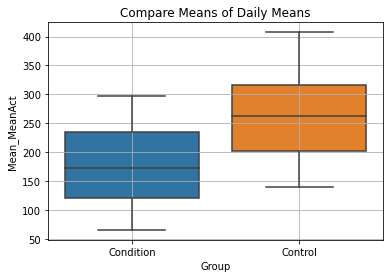

In [23]:
sns.boxplot(data=combined_stats, x='Group', y='Mean_MeanAct')
plt.title('Compare Means of Daily Means')
plt.grid()
plt.show()


### Scores analysis

In [24]:
df = pd.read_csv('./scores.csv')

In [26]:
df_condition = df[df.number.str.contains('condition')].copy()
df_control = df[df.number.str.contains('control')].copy()
features_num = ['days','madrs1','madrs2','DeltaMADRS']
features_cat = ['age', 'gender', 'afftype', 'melanch', 'inpatient', 'edu', 'marriage', 'work']

#### Effect of categorical features on scores

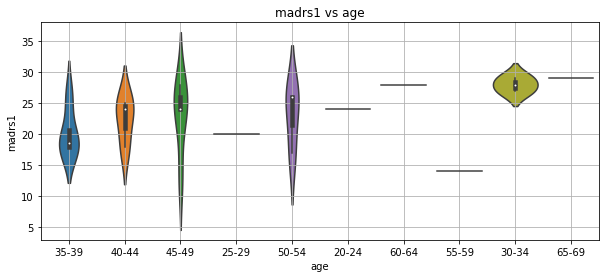

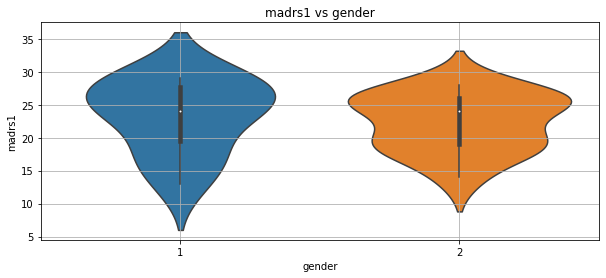

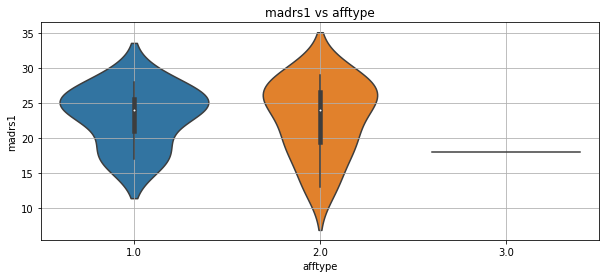

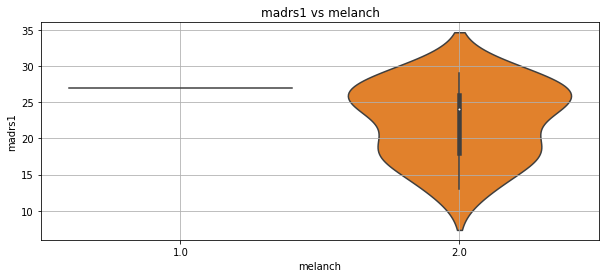

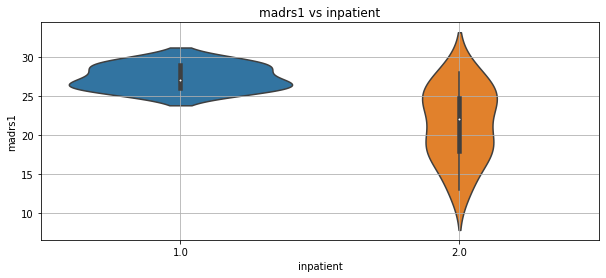

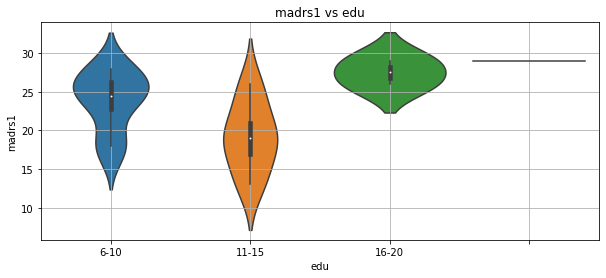

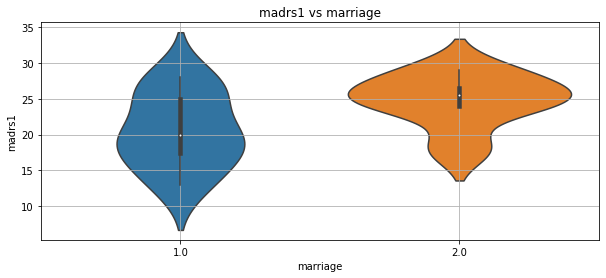

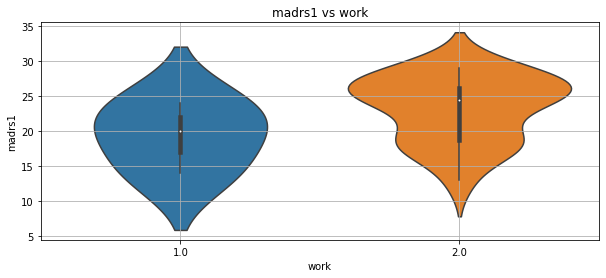

In [27]:
for f in features_cat:
    plt.figure(figsize=(10,4))
    sns.violinplot(data=df_condition, x=f, y='madrs1')
    plt.title('madrs1 vs ' + f)
    plt.grid()
    plt.show()